Shoutout to https://www.linkedin.com/in/vrutik-soni/ for training the models :)

In [ ]:
!unzip -q /content/LULC.zip

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import models
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np

if torch.cuda.is_available():
    device=torch.device(type="cuda",index=0)
else:
    device=torch.device(type="cpu",index=0)

print(device)

**CIFAR-10 with predefined Resnet18**

In [ ]:
# Load and preprocess CIFAR-10 dataset

# Dataset description: https://www.cs.toronto.edu/~kriz/cifar.html
# classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 for ResNet
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize
])

train_dataset=torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset=torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

batch_size=64

train_dl=DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    num_workers=2,
    shuffle=True
)
test_dl=DataLoader(
    dataset=test_dataset,
    batch_size=batch_size
)

In [ ]:

print(test_dataset)


In [ ]:
# Load pre-trained ResNet18 model
model = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)  # Change the final layer to match CIFAR-10 classes
model = model.to(device)

# Define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
#criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
def train_one_epoch(dataloader, model, loss_fn, optimizer):
    model.train()
    track_loss=0
    num_correct=0
    for i, (imgs, labels) in enumerate(dataloader):
        imgs=imgs.to(device)
        labels=labels.to(device)
        pred=model(imgs)
        loss=loss_fn(pred,labels)
        track_loss+=loss.item()
        num_correct+=(torch.argmax(pred,dim=1)==labels).type(torch.float).sum().item()

        running_loss=round(track_loss/(i+(imgs.shape[0]/batch_size)),2)
        running_acc=round((num_correct/((i*batch_size+imgs.shape[0])))*100,2)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if i%100==0:
            print("Batch:", i+1, "/",len(dataloader), "Running Loss:",running_loss, "Running Accuracy:",running_acc)

    epoch_loss=running_loss
    epoch_acc=running_acc
    return epoch_loss, epoch_acc

In [ ]:
#Evaluate the model
def eval(dataloader, model, loss_fn):
    model.eval()
    #data=pd.read_csv(path)
    with torch.no_grad():
        for i, (imgs,labels) in enumerate(dataloader):
            imgs=imgs.to(device)
            pred=model(imgs)
            pred=torch.argmax(pred,dim=1).type(torch.int).cpu()
            print(pred)

In [ ]:
#print(model)
n_epochs=5
for i in range(n_epochs):
    print("Epoch No:",i+1)
    train_epoch_loss, train_epoch_acc=train_one_epoch(train_dl, model, loss_fn, optimizer)
    print("Training:", "Epoch Loss:", train_epoch_loss, "Epoch Accuracy:", train_epoch_acc)
    print("--------------------------------------------------")


Epoch No: 1
Batch: 1 / 782 Running Loss: 2.46 Running Accuracy: 12.5
Batch: 101 / 782 Running Loss: 0.92 Running Accuracy: 68.6
Batch: 201 / 782 Running Loss: 0.78 Running Accuracy: 73.33
Batch: 301 / 782 Running Loss: 0.72 Running Accuracy: 75.66
Batch: 401 / 782 Running Loss: 0.67 Running Accuracy: 77.4
Batch: 501 / 782 Running Loss: 0.63 Running Accuracy: 78.47
Batch: 601 / 782 Running Loss: 0.6 Running Accuracy: 79.51
Batch: 701 / 782 Running Loss: 0.58 Running Accuracy: 80.26
Training: Epoch Loss: 0.56 Epoch Accuracy: 80.78
--------------------------------------------------
Epoch No: 2
Batch: 1 / 782 Running Loss: 0.31 Running Accuracy: 90.62
Batch: 101 / 782 Running Loss: 0.35 Running Accuracy: 88.15
Batch: 201 / 782 Running Loss: 0.35 Running Accuracy: 88.22
Batch: 301 / 782 Running Loss: 0.35 Running Accuracy: 87.99
Batch: 401 / 782 Running Loss: 0.35 Running Accuracy: 87.95
Batch: 501 / 782 Running Loss: 0.35 Running Accuracy: 88.03
Batch: 601 / 782 Running Loss: 0.35 Running 

In [ ]:
eval(test_dl, model, loss_fn)
print(f"Test Accuracy:{test_acc:.2f}%")

Test Accuracy:88.10%


Display 5 images from each of the 10 classes


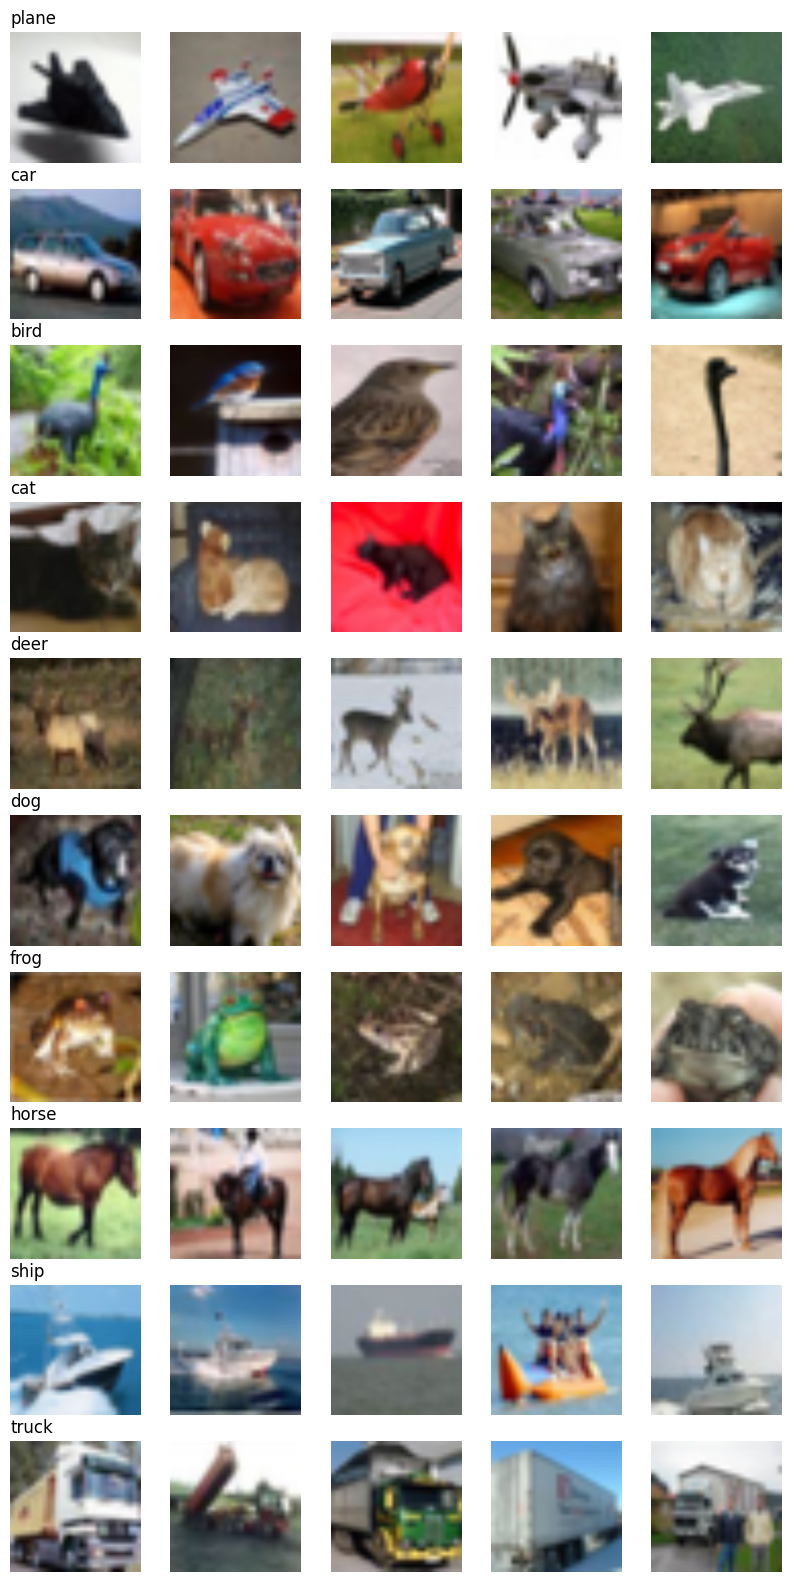

In [ ]:
def display_images_from_classes(dataset, classes, num_images=5):
    images_per_class = {cls: [] for cls in classes}

    for img, label in dataset:
        if len(images_per_class[classes[label]]) < num_images:
            images_per_class[classes[label]].append(img)
        if all(len(images) == num_images for images in images_per_class.values()):
            break

    fig, axs = plt.subplots(len(classes), num_images, figsize=(num_images * 2, len(classes) * 2))
    for i, cls in enumerate(classes):
        for j in range(num_images):
            img = images_per_class[cls][j]
            img = img / 2 + 0.5  # Unnormalize the image
            npimg = img.numpy()
            axs[i, j].imshow(np.transpose(npimg, (1, 2, 0)))
            axs[i, j].axis('off')
            if j == 0:
                axs[i, j].set_title(cls, loc='left')

    plt.show()

# Classes of CIFAR-10
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Display images
display_images_from_classes(train_dataset, classes)


Display test images with predicted class labels

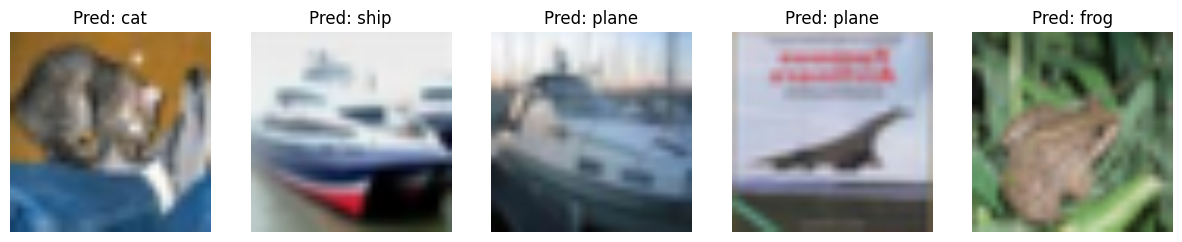

In [ ]:
def display_predictions(model, dataloader, classes, num_images=5):
    model.eval()
    images_shown = 0

    fig, axs = plt.subplots(1, num_images, figsize=(num_images * 3, 3))

    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs, labels = imgs.to(device), labels.to(device)
            preds = model(imgs)
            _, preds_labels = torch.max(preds, 1)

            for i in range(imgs.shape[0]):
                if images_shown < num_images:
                    img = imgs[i] / 2 + 0.5  # Unnormalize the image
                    npimg = img.cpu().numpy()
                    axs[images_shown].imshow(np.transpose(npimg, (1, 2, 0)))
                    axs[images_shown].set_title(f"Pred: {classes[preds_labels[i]]}")
                    axs[images_shown].axis('off')
                    images_shown += 1
                if images_shown == num_images:
                    break
            if images_shown == num_images:
                break

    plt.show()

# Display test images with predicted class labels
display_predictions(model, test_dl, classes)


**CIAFR-10 with resnet18 as a fixed feature extractor (adding a new classifier head)**

In [ ]:
# Load pre-trained ResNet18 model
model = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(0.5),

    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.5),

    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Dropout(0.5),

    nn.Linear(128, 10)
)

model = model.to(device)

# Define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
n_epochs = 5  # Adjust the number of epochs as needed

for epoch in range(n_epochs):
    print(f"Epoch {epoch+1}/{n_epochs}")
    train_epoch_loss, train_epoch_acc = train_one_epoch(train_dl, model, loss_fn, optimizer)
    print(f"Training Loss: {train_epoch_loss:.4f}, Training Accuracy: {train_epoch_acc:.2f}%")
    print("-" * 50)


Epoch 1/5
Batch: 1 / 782 Running Loss: 0.8 Running Accuracy: 82.81
Batch: 101 / 782 Running Loss: 0.99 Running Accuracy: 65.47
Batch: 201 / 782 Running Loss: 0.94 Running Accuracy: 67.75
Batch: 301 / 782 Running Loss: 0.92 Running Accuracy: 68.93
Batch: 401 / 782 Running Loss: 0.9 Running Accuracy: 69.94
Batch: 501 / 782 Running Loss: 0.88 Running Accuracy: 71.01
Batch: 601 / 782 Running Loss: 0.86 Running Accuracy: 71.83
Batch: 701 / 782 Running Loss: 0.84 Running Accuracy: 72.55
Training Loss: 0.8300, Training Accuracy: 73.09%
--------------------------------------------------
Epoch 2/5
Batch: 1 / 782 Running Loss: 0.49 Running Accuracy: 85.94
Batch: 101 / 782 Running Loss: 0.68 Running Accuracy: 78.73
Batch: 201 / 782 Running Loss: 0.67 Running Accuracy: 79.4
Batch: 301 / 782 Running Loss: 0.66 Running Accuracy: 79.72
Batch: 401 / 782 Running Loss: 0.66 Running Accuracy: 79.96
Batch: 501 / 782 Running Loss: 0.65 Running Accuracy: 80.15
Batch: 601 / 782 Running Loss: 0.64 Running Acc

**ON LULC DATASET with predefined resnet18**


Dataset has been taken from https://www.kaggle.com/datasets/abdulhasibuddin/uc-merced-land-use-dataset

In [ ]:
!unzip -q /content/LULC.zip


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from torchvision import models
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image

if torch.cuda.is_available():
    device = torch.device(type="cuda", index=0)
else:
    device = torch.device(type="cpu", index=0)

print(device)

# Custom Dataset for Land Use Land Cover (LULC)
class CustomLULCDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = os.listdir(root_dir)
        self.image_paths = []
        self.labels = []

        for label, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            if os.path.isdir(class_dir):
                for img_name in os.listdir(class_dir):
                    img_path = os.path.join(class_dir, img_name)
                    if os.path.isfile(img_path):
                        self.image_paths.append(img_path)
                        self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")  # Convert image to RGB
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 for ResNet
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize
])

# Load the entire dataset (LULC images in 21 folders under 'images' directory)
dataset = CustomLULCDataset('/content/UCMerced_LandUse/UCMerced_LandUse', transform=transform)

# Print dataset size to debug
print(f"Total images loaded: {len(dataset)}")

# Split the dataset into train and test sets (80% train, 20% test)
if len(dataset) > 0:
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
else:
    raise ValueError("Dataset is empty. Check the root directory and file structure.")

batch_size = 64

train_dl = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)
test_dl1 = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
)

cuda:0
Total images loaded: 2100


In [ ]:
# Load pre-trained ResNet18 model
model = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 21)
model = model.to(device)

# Define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
#criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
def train_one_epoch(dataloader, model, loss_fn, optimizer):
    model.train()
    track_loss=0
    num_correct=0
    for i, (imgs, labels) in enumerate(dataloader):
        imgs=imgs.to(device)
        labels=labels.to(device)
        pred=model(imgs)
        loss=loss_fn(pred,labels)
        track_loss+=loss.item()
        num_correct+=(torch.argmax(pred,dim=1)==labels).type(torch.float).sum().item()

        running_loss=round(track_loss/(i+(imgs.shape[0]/batch_size)),2)
        running_acc=round((num_correct/((i*batch_size+imgs.shape[0])))*100,2)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if i%100==0:
            print("Batch:", i+1, "/",len(dataloader), "Running Loss:",running_loss, "Running Accuracy:",running_acc)

    epoch_loss=running_loss
    epoch_acc=running_acc
    return epoch_loss, epoch_acc

In [ ]:
def eval(dataloader, model, loss_fn):
    model.eval()
    num_correct = 0
    total_samples = 0
    #data=pd.read_csv(path)
    with torch.no_grad():
        for i, (imgs,labels) in enumerate(dataloader):
            imgs=imgs.to(device)
            pred=model(imgs)
            pred=torch.argmax(pred,dim=1).type(torch.int).cpu()
            #print(pred) # Remove or comment out this line to avoid printing predictions during evaluation

            # Calculate accuracy for this batch
            num_correct += (pred == labels.cpu()).sum().item()
            total_samples += labels.size(0)

    # Calculate and return overall accuracy
    accuracy = (num_correct / total_samples) * 100
    return accuracy

In [ ]:
#print(model)
n_epochs=5
for i in range(n_epochs):
    print("Epoch No:",i+1)
    train_epoch_loss, train_epoch_acc=train_one_epoch(train_dl, model, loss_fn, optimizer)
    print("Training:", "Epoch Loss:", train_epoch_loss, "Epoch Accuracy:", train_epoch_acc)
    print("--------------------------------------------------")

Epoch No: 1
Batch: 1 / 27 Running Loss: 3.27 Running Accuracy: 3.12
Training: Epoch Loss: 0.84 Epoch Accuracy: 76.13
--------------------------------------------------
Epoch No: 2
Batch: 1 / 27 Running Loss: 0.21 Running Accuracy: 95.31
Training: Epoch Loss: 0.34 Epoch Accuracy: 89.52
--------------------------------------------------
Epoch No: 3
Batch: 1 / 27 Running Loss: 0.35 Running Accuracy: 90.62
Training: Epoch Loss: 0.31 Epoch Accuracy: 91.9
--------------------------------------------------
Epoch No: 4
Batch: 1 / 27 Running Loss: 0.6 Running Accuracy: 87.5
Training: Epoch Loss: 0.25 Epoch Accuracy: 93.51
--------------------------------------------------
Epoch No: 5
Batch: 1 / 27 Running Loss: 0.21 Running Accuracy: 93.75
Training: Epoch Loss: 0.21 Epoch Accuracy: 94.29
--------------------------------------------------


In [ ]:
test_acc=eval(test_dl1, model, loss_fn)
print(f"Test Accuracy:{test_acc:.2f}%")

Test Accuracy:93.57%


**On LULC dataset (https://www.kaggle.com/datasets/abdulhasibuddin/uc-merced-land-use-dataset) with predefined VGG16 model by changing only the classifier head weights (using the model as a fixed feature extractor)**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from torchvision import models
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image

if torch.cuda.is_available():
    device = torch.device(type="cuda", index=0)
else:
    device = torch.device(type="cpu", index=0)

print(device)

# Custom Dataset for Land Use Land Cover (LULC)
class CustomLULCDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = os.listdir(root_dir)
        self.image_paths = []
        self.labels = []

        for label, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            if os.path.isdir(class_dir):
                for img_name in os.listdir(class_dir):
                    img_path = os.path.join(class_dir, img_name)
                    if os.path.isfile(img_path):
                        self.image_paths.append(img_path)
                        self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")  # Convert image to RGB
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 for V1GG16
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize
])

# Load the entire dataset (LULC images in 21 folders under 'images' directory)
dataset = CustomLULCDataset('/content/UCMerced_LandUse/UCMerced_LandUse', transform=transform)

# Print dataset size to debug
print(f"Total images loaded: {len(dataset)}")

# Split the dataset into train and test sets (80% train, 20% test)
if len(dataset) > 0:
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
else:
    raise ValueError("Dataset is empty. Check the root directory and file structure.")

batch_size = 64

train_dl = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)
test_dl1 = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
)

# Load pre-trained VGG16 model
model = models.vgg16(weights='IMAGENET1K_V1')
num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs, 21)  # Change the final layer to 21 classes
model = model.to(device)

# Define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_one_epoch(dataloader, model, loss_fn, optimizer):
    model.train()
    track_loss=0
    num_correct=0
    for i, (imgs, labels) in enumerate(dataloader):
        imgs=imgs.to(device)
        labels=labels.to(device)
        pred=model(imgs)
        loss=loss_fn(pred,labels)
        track_loss+=loss.item()
        num_correct+=(torch.argmax(pred,dim=1)==labels).type(torch.float).sum().item()

        running_loss=round(track_loss/(i+(imgs.shape[0]/batch_size)),2)
        running_acc=round((num_correct/((i*batch_size+imgs.shape[0])))*100,2)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if i%100==0:
            print("Batch:", i+1, "/",len(dataloader), "Running Loss:",running_loss, "Running Accuracy:",running_acc)

    epoch_loss=running_loss
    epoch_acc=running_acc
    return epoch_loss, epoch_acc

def eval(dataloader, model, loss_fn):
    model.eval()
    num_correct = 0
    total_samples = 0
    with torch.no_grad():
        for i, (imgs,labels) in enumerate(dataloader):
            imgs=imgs.to(device)
            pred=model(imgs)
            pred=torch.argmax(pred,dim=1).type(torch.int).cpu()

            # Calculate accuracy for this batch
            num_correct += (pred == labels.cpu()).sum().item()
            total_samples += labels.size(0)

    # Calculate and return overall accuracy
    accuracy = (num_correct / total_samples) * 100
    return accuracy

n_epochs = 5
for i in range(n_epochs):
    print("Epoch No:", i+1)
    train_epoch_loss, train_epoch_acc = train_one_epoch(train_dl, model, loss_fn, optimizer)
    print("Training:", "Epoch Loss:", train_epoch_loss, "Epoch Accuracy:", train_epoch_acc)
    print("--------------------------------------------------")

test_acc = eval(test_dl1, model, loss_fn)
print(f"Test Accuracy: {test_acc:.2f}%")


cuda:0
Total images loaded: 2100
Epoch No: 1
Batch: 1 / 27 Running Loss: 3.15 Running Accuracy: 0.0
Training: Epoch Loss: 3.22 Epoch Accuracy: 4.52
--------------------------------------------------
Epoch No: 2
Batch: 1 / 27 Running Loss: 3.22 Running Accuracy: 6.25
Training: Epoch Loss: 3.12 Epoch Accuracy: 5.83
--------------------------------------------------
Epoch No: 3
Batch: 1 / 27 Running Loss: 2.91 Running Accuracy: 6.25
Training: Epoch Loss: 2.77 Epoch Accuracy: 12.02
--------------------------------------------------
Epoch No: 4
Batch: 1 / 27 Running Loss: 3.18 Running Accuracy: 10.94
Training: Epoch Loss: 2.61 Epoch Accuracy: 15.65
--------------------------------------------------
Epoch No: 5
Batch: 1 / 27 Running Loss: 2.48 Running Accuracy: 14.06
Training: Epoch Loss: 2.54 Epoch Accuracy: 19.94
--------------------------------------------------
Test Accuracy: 18.81%


**On LULC dataset (https://www.kaggle.com/datasets/abdulhasibuddin/uc-merced-land-use-dataset) with predefined VGG16 model but this time by updating all weights**

In [ ]:
import os
import random
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn as nn
import cv2  # For image reading
from sklearn.model_selection import train_test_split

# Set device to CPU
device = torch.device("cuda")
print("Using device:", device)


# Custom Dataset Class
class LandUseDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []

        # Load images and labels based on folder structure
        for label, class_dir in enumerate(os.listdir(root_dir)):
            class_dir_path = os.path.join(root_dir, class_dir)
            if os.path.isdir(class_dir_path):
                for img_file in os.listdir(class_dir_path):
                    img_path = os.path.join(class_dir_path, img_file)
                    self.images.append(img_path)
                    self.labels.append(label)  # Use folder index as label

        self.images = np.array(self.images)
        self.labels = np.array(self.labels)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = cv2.imread(self.images[idx])
        image = cv2.resize(image, (64, 64))  # Resize to 64x64 for faster training
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image, label

# Image Transformations with Augmentations
transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert from NumPy array to PIL
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.RandomRotation(10),  # Randomly rotate images by 10 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Random changes in brightness, contrast, etc.
    transforms.ToTensor(),  # Convert back to tensor
])

# Load dataset
dataset = LandUseDataset('/content/UCMerced_LandUse/UCMerced_LandUse', transform=transform)

# Train-test split
train_indices, test_indices = train_test_split(np.arange(len(dataset)), test_size=0.2, random_state=42)
train_subset = torch.utils.data.Subset(dataset, train_indices)
test_subset = torch.utils.data.Subset(dataset, test_indices)

# Batch size adjustment for CPU
batch_size = 16
train_dl = DataLoader(dataset=train_subset, batch_size=batch_size, shuffle=True, num_workers=2)
test_dl = DataLoader(dataset=test_subset, batch_size=batch_size, shuffle=False, num_workers=2)

# Load Pre-trained VGG16 model
model = models.vgg16(pretrained=True)

# Fine-tune some layers in VGG16
for param in model.features[:10]:
    param.requires_grad = True

# Modify the classifier to match the number of classes (21 in this case)
model.classifier[6] = nn.Linear(4096, 21)

# Move the model to the device
model = model.to(device)

# Define loss function and optimizer with weight decay (L2 regularization)
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Training Function
def train_one_epoch(dataloader, model, loss_fn, optimizer):
    model.train()
    track_loss = 0
    num_correct = 0
    for i, (imgs, labels) in enumerate(dataloader):
        imgs = imgs.to(device)
        labels = labels.to(device)
        pred = model(imgs)

        loss = loss_fn(pred, labels)

        track_loss += loss.item()
        num_correct += (torch.argmax(pred, dim=1) == labels).sum().item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if i % 100 == 0:
            running_loss = track_loss / (i + 1)
            running_acc = num_correct / ((i + 1) * batch_size) * 100
            print(f"Batch {i + 1}/{len(dataloader)}, Loss: {running_loss:.4f}, Accuracy: {running_acc:.4f}")

    return track_loss / len(dataloader), num_correct / len(dataloader.dataset) * 100

# Evaluation Function
def eval(dataloader, model):
    model.eval()
    num_correct = 0
    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            pred = model(imgs)
            num_correct += (torch.argmax(pred, dim=1) == labels).sum().item()

    return num_correct / len(dataloader.dataset) * 100

# Training Loop with Early Stopping
n_epochs = 20  # Increase number of epochs
early_stopping_patience = 3  # Stop training if no improvement in 3 epochs
best_val_acc = 0
epochs_no_improve = 0

for epoch in range(n_epochs):
    print(f"Epoch {epoch + 1}")
    train_epoch_loss, train_epoch_acc = train_one_epoch(train_dl, model, loss_fn, optimizer)
    print(f"Training: Epoch Loss: {train_epoch_loss:.4f}, Epoch Accuracy: {train_epoch_acc:.4f}")

    # Validation accuracy
    val_epoch_acc = eval(test_dl, model)
    print(f"Validation Accuracy: {val_epoch_acc:.4f}")

    # Early stopping check
    if val_epoch_acc > best_val_acc:
        best_val_acc = val_epoch_acc
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve == early_stopping_patience:
        print("Early stopping triggered.")
        break

    # Step the learning rate scheduler
    scheduler.step()

print("Training complete.")
print("--------------------------------------------------")
test_accuracy = eval(test_dl, model)
print(f"Test Accuracy: {test_accuracy:.4f}")


Using device: cuda
Epoch 1
Batch 1/105, Loss: 3.1791, Accuracy: 12.5000
Batch 101/105, Loss: 3.0511, Accuracy: 6.7450
Training: Epoch Loss: 3.0463, Epoch Accuracy: 6.9643
Validation Accuracy: 6.4286
Epoch 2
Batch 1/105, Loss: 3.2415, Accuracy: 0.0000
Batch 101/105, Loss: 2.7234, Accuracy: 13.1807
Training: Epoch Loss: 2.7169, Epoch Accuracy: 13.3929
Validation Accuracy: 13.8095
Epoch 3
Batch 1/105, Loss: 2.7167, Accuracy: 18.7500
Batch 101/105, Loss: 2.6652, Accuracy: 13.9851
Training: Epoch Loss: 2.6650, Epoch Accuracy: 13.8690
Validation Accuracy: 10.4762
Epoch 4
Batch 1/105, Loss: 2.6913, Accuracy: 18.7500
Batch 101/105, Loss: 2.6130, Accuracy: 14.5421
Training: Epoch Loss: 2.6091, Epoch Accuracy: 14.6429
Validation Accuracy: 17.6190
Epoch 5
Batch 1/105, Loss: 2.4786, Accuracy: 0.0000
Batch 101/105, Loss: 2.5444, Accuracy: 18.1931
Training: Epoch Loss: 2.5391, Epoch Accuracy: 18.4524
Validation Accuracy: 14.2857
Epoch 6
Batch 1/105, Loss: 2.2772, Accuracy: 31.2500
Batch 101/105, Los